# TP IMED 02: MR IMAGE SEGMENTATION AND ANALYSIS

The goal of this 3-hour session is to perform classical segmentation algorithms on brain MR images and to make prediction from the segmentations. The provided code, in Python, is uncomplete and you need to complete it to run successfully the algorithms. Exercises are indicated in red. 

In [68]:
#System imports
from __future__ import print_function
from __future__ import division
import os
import glob
import json
import collections
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [69]:
#Extra import
%matplotlib inline
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
from scipy import ndimage
import progressbar #not essential to the session

## Segmentation

We propose to work with MR images from patients with gliomas (<font color='blue'>[Menze et al., TMI, 2015]</font>). The available data for each patient consist in manual segmentation, pre-processed Gadolinium enhanced T1w and FLAIR nifti images acquired in a single time session. The pre-processing steps were the following:

- rigid co-registration of each FLAIR on the T1-GDw image of the same patient, using a mutual information criterion (and ITK !),
- T1Gd and FLAIR resampling to have 1-isotropic voxel and axial orientation,
- brain removal.

Here, the dataset has been modified to follow the BIDS convention (see https://bids.neuroimaging.io/ for more information).

In [247]:
#Get the database directory
datapath = os.path.join(os.path.dirname(os.getcwd()), "DB2_short")

In [248]:
#Get the T1Gd image path from a specific subject
sid = "sub-094"
impath = os.path.join(datapath, "sourcedata", sid, "ses-01", "anat", "{0}_ses-01_ce-GADOLINIUM_T1w.nii.gz".format(sid))
print(impath)

C:\Users\helen\Documents\enseignement\epita2019\IMED\DB2\sourcedata\sub-094\ses-01\anat\sub-094_ses-01_ce-GADOLINIUM_T1w.nii.gz


In [249]:
#Load the nifti image
im = nib.load(impath)
im_arr = im.get_data()

print("Image dimension:", im.shape)
print("Voxel size (mm):", im.header.get_zooms())
sx, sy, sz = im.shape

Image dimension: (240, 240, 155)
Voxel size (mm): (1.0, 1.0, 1.0)


Let's first try to get the brain mask, here the image foreground. We propose to extract the brain mask using the Otsu thresholding method.

<font color='red'>Define the Otsu's thresholding function (you may reuse a previously coded function or even use a function from a library, but make sure that it does work with 3D images).</font> 

In [250]:
#Define the Otsu thresholding function 
def otsu(im_arr, mask_arr):
    
    """Otsu thresholding function  

    im_arr: array,
        the mr image array
    mask_arr: array
        the binary mask array
        
    Outputs:   
    threshold_val: float,
        the threshold value
    """
        
     #... To complete ...
    
    return threshold_val

<font color='red'>Extract the brain mask using the 3D Otsu's method. Complete the following code cell to with post-processing steps to improve the segmentation.</font> 

In [251]:
#Compute the brain mask using a 3D Otsu thresholding method
thresh_val = otsu(im_arr, np.ones((sx, sy, sz)))
brain_arr = (im_arr >= thresh_val).astype(int)

# Fill the holes in the brain mask (you may use the Scipy binary_fill_holes function)
for mr_slice in range(0, sz):
    brain_arr[:, :, mr_slice] = ndimage.binary_fill_holes(brain_arr[:, :, mr_slice]).astype(int)

def show_result(im_arr, seg_arr, mr_slice):
    """ Superimpose the MR slice image and the segmentation contour
    Inputs:
    im_arr: 3D array,
        the mr image array
    seg_arr: 3D array
        the binary segmentation array
    mr_slice: int,
        the MR slice to show
    Outputs:   
    threshold_val: float,
        the threshold value   
    """
    plt.imshow(im_arr[:,:,mr_slice].T, cmap="gray")
    plt.contour(seg_arr[:,:,mr_slice].T, colors="r", linewidths=1, levels=[0.5, 1])
    plt.axis('off')
    plt.pause(0.1)

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(brain_arr), mr_slice=(0, sz, 1))
interactive_plot 

interactive(children=(IntSlider(value=77, description='mr_slice', max=155), Output()), _dom_classes=('widget-i…

Now we extracted the brain mask, let's find tumor markers. We hypothesize that a tumor distribution in intensity differs from the one of the healthy tissues. Thus, we are going to try entropy thresholding as a initialization step.

<font color='red'>Define the maximum entropy thresholding function (make sure it works with 3D images).</font> 

In [252]:
#Define the maximum entropy thresholding function 
def max_entropy(im_arr, mask_arr):

    """Maximum entropy thresholding function 
    Inputs:
    im_arr: array,
        the mr image array
    mask_arr: array
        the binary mask array
        
    Outputs:   
    threshold_val: float,
        the threshold value
    """
    
     #... To complete ...
    
    return threshold_val

<font color='red'>Get tumor markers using a 3D maximum entropy thresholding. Complete the following code cell to improve the segmentation.</font> 

In [253]:
#Initialize the tumor segmentation with a 3D maximum entropy thresholding
thresh_val = max_entropy(im_arr, brain_arr)
init_seg_arr = (im_arr >= thresh_val).astype(int) 

#Fill the holes in the segmentation array (you may use the Scipy binary_fill_holes function)
#... To complete ...
    
#Extract only the connected component of highest volume (26-connectivity) 
#You may use the Scipy label function...
init_seg_arr =   #... To complete ...

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(init_seg_arr), mr_slice=(0, sz - 1, 1))
interactive_plot 

interactive(children=(IntSlider(value=77, description='mr_slice', max=154), Output()), _dom_classes=('widget-i…

The segmentation we obtained is quite good actually ! Let's try to improve it using a more sophisticated algorithm, as the Watershed algorithm <font color='blue'>[Beucher, S. and Lantuéjoul, C., 1979] </font>. 
To that purpose, you will find a simplified implementation of the Watershed algorithm in the cell below.

<font color='red'>Read the code below and ensure that you understand the algorithm steps. </font> 

In [260]:
#Home made watershed with markers !
def homemade_watershed(im_arr, mask_arr, markers_arr, se):
    """ Watershed segmentation
    Inputs:
    im_arr: 2D or 3D array,
        the mr image array
    mask_arr: 2D or 3D array
        the binary mask array
    markers_arr: 2D or 3D array,
        the labelled marker array 
    se: 3x3 or 3x3x3 array,
        the structuring element defining the connectivity
    Outputs:   
    seg_arr: 2D or 3D array,
        the segmentation array    
    """
        
    #Requantize the image array to reduce computation time and gray levels
    im_arr = 255 * (im_arr - np.min(im_arr[mask_arr == 1])) / (np.max(im_arr[mask_arr == 1]) - np.min(im_arr[mask_arr == 1]))
    im_arr = im_arr.astype(int)

    #Sort the intensity value from lowest to highest value    
    intensity_vals = list(np.unique(im_arr[mask_arr > 0]))
    intensity_vals.sort()
    #print("{0} grey levels to process".format(len(intensity_vals)))
          
    seg_arr = np.zeros(im_arr.shape).astype(int)
    ##remove the line below and reduce the indent if the progressbar library is not loaded
    with progressbar.ProgressBar(max_value=len(intensity_vals), redirect_stdout=True) as bar:
        #Go through each intensity value, sorted in ascent order
        for cnt_k, k in enumerate(intensity_vals):

            #Level set at level k
            kls_arr = np.logical_and(mask_arr > 0, im_arr == k).astype(int)

            #Union between the k level set and the previous segmentation
            kseg_arr = np.logical_or(kls_arr, seg_arr > 0).astype(int)

            #Connected components    
            ccs_arr, nb_ccs = ndimage.label(kseg_arr, structure=se)

            #Get the connected components (cc) including a marker
            ccs_with_markers = np.unique(ccs_arr[markers_arr != 0])
            ccs_with_markers = list(ccs_with_markers[ccs_with_markers != 0])

            #For each cc with markers, check if there is only one marker included
            for cc_id in ccs_with_markers:
                marker_ids = np.unique(markers_arr[ccs_arr == cc_id])
                marker_ids = list(marker_ids[marker_ids != 0])

                #If so, add the whole cc area into the segmentation of the region
                #associated with the marker
                if len(marker_ids) == 1:
                    seg_arr[ccs_arr == cc_id] = marker_ids[0]

            #Update the progress bar 
            bar.update(cnt_k) #remove this line and reduce the indent if the progressbar library is not loaded
            
    return seg_arr        

<font color='red'>Try the 2D version of the homemade watershed algorithm on the 77th axial MR slice.
- According to the code implementation, choose wisely the function input.
- Use 8-connectivity.    
- Take the labelled mr slice local maxima as initial markers (use the Scipy label function to obtain a labelled image).
- Comment the result.    
</font> 

  2% (49 of 1963) |                      | Elapsed Time: 0:00:00 ETA:   0:00:06

1963 grey levels to process


100% (1963 of 1963) |####################| Elapsed Time: 0:00:13 Time:  0:00:13


(-0.5, 239.5, 239.5, -0.5)

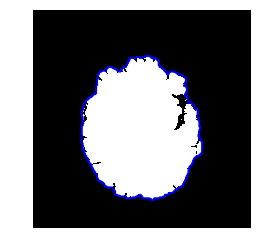

In [256]:
#Test the homemade watershed on the 55th axial MR slice
mr_slice = 69

#Define the MR slice array
slice_arr = im_arr[:, :, mr_slice]

#Define the 8-connectivity array
se =      #... To complete ...

#Marker initialization
markers_arr =  #... To complete ...

#2D Watershed segmentation
seg_arr =  homemade_watershed   #... To complete ...

#Show the result on the MR slice
plt.imshow(seg_arr.T, cmap="gray")
plt.contour(markers_arr.T, colors="b", linewidths=1, levels=[0.5, 1])
plt.axis('off')

<font color='red'>Try the 2D version of the homemade watershed algorithm on the 76th axial MR slice.
- According to the code implementation, choose wisely the function input.
- Use 8-connectivity. 
- Use intern and extern tumor markers.    
- Comment the result.    
</font> 

  5% (100 of 1963) |#                    | Elapsed Time: 0:00:00 ETA:   0:00:03

1963 grey levels to process


100% (1963 of 1963) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


(-0.5, 239.5, 239.5, -0.5)

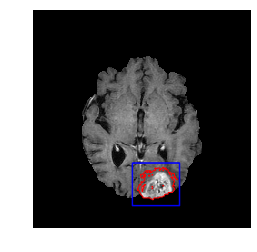

In [257]:
#Test the homemade watershed on one MR slice
mr_slice = 69

#Initialization:
#Intern markers = initial segmentation 
#Extern markers = initial segmentation bounding box + p pixels
p = 10
markers_arr = np.zeros((sx, sy))
[x, y] = np.where(init_seg_arr[:, :, mr_slice] != 0)
bb_arr = np.zeros((sx, sy))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr[:, :, mr_slice] == 1] = 1

#Define the 8-connectivity array
se = #... To complete ...

#2D Watershed segmentation
seg_arr = homemade_watershed(#... To complete ...)

#Extract the segmentation obtained from the intern markers
seg_arr = (seg_arr == 1).astype(int)

#Show the result on the 44th axial MR slice
plt.imshow(im_arr[:, :, mr_slice].T, cmap="gray")
plt.contour(markers_arr.T, colors="b", linewidths=1, levels=[1.5, 2])
plt.contour(seg_arr.T, colors="r", linewidths=1, levels=[0.5, 1])
plt.axis('off')

<font color='red'>Try the homemade watershed algorith on all the MR slices (2D version)
</font> 

In [261]:
#2D watershed slice by slice

se = #... To complete ...
seg2d_arr = np.ones((sx, sy, sz))

#Initialization
markers_arr = np.zeros((sx, sy, sz))
[x, y, z] = np.where(init_seg_arr != 0)
p = 10
bb_arr = np.zeros((sx, sy, sz))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p, np.min(z) - p:np.max(z) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr == 1] = 1

#2D watershed segmentation, MR axial slice by MR axial slice
for mr_slice in range(0, sz):
    if np.count_nonzero(init_seg_arr[:, :, mr_slice]) > 0:    
        seg2d_arr[:, :, mr_slice] = homemade_watershed(#... To complete ...)

#Restrict the segmentation to the tumor class     
seg2d_arr = (seg2d_arr == 1).astype(int)

#Fill holes
seg2d_arr = #... To complete ...
            
#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(seg2d_arr), mr_slice=(0, sz - 1, 1))
interactive_plot

100% (1568 of 1568) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1613 of 1613) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1655 of 1655) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1705 of 1705) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1762 of 1762) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1819 of 1819) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1849 of 1849) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1868 of 1868) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1897 of 1897) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1904 of 1904) |####################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (1924 of 1924) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1935 of 1935) |####################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (1942 of 1942) |###################

interactive(children=(IntSlider(value=77, description='mr_slice', max=154), Output()), _dom_classes=('widget-i…

<font color='red'>Try the homemade watershed algorith on the whole volume (3D version).
</font> 

In [262]:
#Initialization
markers_arr = np.zeros((sx, sy, sz))
[x, y, z] = np.where(init_seg_arr != 0)
p = 10
bb_arr = np.zeros((sx, sy, sz))
bb_arr[np.min(x) - p:np.max(x) + p, np.min(y) - p:np.max(y) + p, np.min(z) - p:np.max(z) + p] = 1
dist_arr = ndimage.distance_transform_edt(bb_arr).astype(int)
markers_arr[np.logical_and(dist_arr > 0, dist_arr < 1.5)] = 2
markers_arr[init_seg_arr == 1] = 1

#3D connectivity array (26-connectivity)
se = seg2d_arr = #... To complete ...


#2D watershed algorithm
seg3d_arr = homemade_watershed( #... To complete ...)

#Get only the tumor segmentation
seg3d_arr = (seg3d_arr == 1).astype(int)

#Fill holes
seg3d_arr = #... To complete ...

#Show the result        
interactive_plot = interactive(show_result, im_arr=fixed(im_arr), seg_arr=fixed(seg3d_arr), mr_slice=(0, sz-1, 1))
interactive_plot

100% (2832 of 2832) |####################| Elapsed Time: 0:01:20 Time:  0:01:20


KeyboardInterrupt: 

The difference between 2D and 3D segmentation may not be easy to assess visually.
We are going to assess the segmentation quality quantitatively.

<font color='red'>For each automatic segmentation type, compute the Dice coefficient between the automatic and manual segmentation, excluding the edema. Comment.
Same using the Hausdorff distance. 
</font> 

## Image analysis

We propose here to predict the tumor grade on the whole database, given in the metadata json file. To that purpose, you need to extract useful tumor biomarkers, and them to perform classification (today we will use machine learning).
We divide this section into three parts.

First, let's have a look at the whole dataset. We are going to create two folders, one with images of patients with low grade gliomas, and one with patients of high grade gliomas. There will be one png image per patient, corresponding to the axial MR slice with the highest tumor area, and showing all the tumor label contours.

<font color='red'>Compare visually the images from the two folders. What biomarker would be interesting ?
</font> 

In [ ]:
#Get the dataset directory
datadir = os.path.join(os.path.dirname(os.getcwd()), "DB2")

#Get the path of the file associating grade to all the patients
metadatapath = os.path.join(datadir, "metadata.json")

#Import the clinical data
with open(metadatapath) as json_file:
    clinics = json.load(json_file)

#Source and process directories    
srcdir = os.path.join(datadir, "sourcedata")
processdir = os.path.join(datadir, "derivatives")

#Get all the subject ids
sids = glob.glob1(processdir, "sub-*")

#Create a color dictionary associated to each tumor label
color_list = ["r", "b", "w", "g", "k", "c"]
colors = {}
for label, color in enumerate(color_list):
    colors[label + 1] = color

#Go through each patient 
with progressbar.ProgressBar(max_value=len(sids), redirect_stdout=True) as bar:   
    for cnt_sid, sid in enumerate(sids):
        #Get the MR image path
        imfile = "{0}_ses-01_ce-GADOLINIUM_T1w.nii.gz".format(sid)
        impath = os.path.join(srcdir, sid, "ses-01", "anat", imfile)
        im = nib.load(impath)
        im_arr = im.get_data()
        spacings = im.header.get_zooms()

        #Get the gt path
        gtfile = "{0}_ses-01_gt.nii.gz".format(sid)
        gtpath = os.path.join(processdir, sid, "ses-01", "anat", gtfile)
        gt = nib.load(gtpath)
        gt_arr = gt.get_data().astype(int)

        #Get the axial mr slice with the highest tumor area 
        mr_slice = # ... To complete ...

        #Plot the result
        fig, ax = plt.subplots()
        gt_slice_arr = gt_arr[:,:,mr_slice]
        labels = np.unique(gt_arr[:,:,mr_slice])
        labels = list(labels[labels != 0])
        ax.imshow(im_arr[:,:,mr_slice].T, cmap="gray")
        for label in labels:
            label_arr = (gt_slice_arr == label).astype(int)
            ax.contour(label_arr.T, linewidths=1, levels=[0.5, 1], colors=colors[label])
        ax.axis('off')
        title = "{0}_ses-01".format(sid)
        ax.set_title(title)
        figdir = os.path.join(os.getcwd(), "figs", clinics[sid])
        
        #Create the figure directory with images of specific grade gliomas if necessary
        if not os.path.isdir(figdir):
            os.makedirs(figdir)
        figpath = os.path.join(figdir, "{0}.png".format(title))
        fig.savefig(figpath)
        
        #Close the figure (otherwise memory warning)
        plt.close(fig)

        #Update the progress bar  
        bar.update(cnt_sid)


Then, we need to extract tumor biomarkers.

<font color='red'>Extract tumor biomarkers from the manual segmentation. Create an array, with as many lines as there are patients, and as many columns as chosen biomarkers.
</font> 

Finally, we will launch a tumor grade classification from the chosen biomarkers. You will use the Scikit-learn library, and perform cross-validation and ROC analysis. Please find below the main example to follow:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
The ROC analysis will assess the prediction quality, an area under the ROC curve greater than 0.5 meaning that you predict better than chance.

In [ ]:
#NB: feature scaling usually improve the prediction. Perform it after each data split.
#from sklearn import preprocessing
#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)